points.shape=(104, 4)
int(img_width)=99, num_equidistant_points=396
Num of strokes: 2


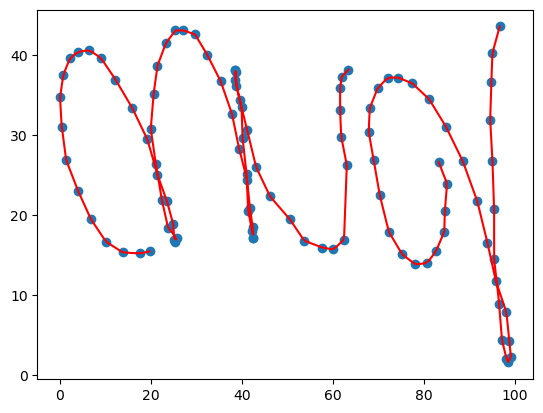

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def get_strokes(word_strokes):
    ''' Get strokes from a word with multiple strokes.'''
    word_strokes[-1, 3] = 1  # Set the EoS flag of the last point to 1
    strokes = []
    SoS_indices = np.where(word_strokes[:, 2] == 1)[0]
    EoS_indices = np.zeros(len(SoS_indices), dtype=int)
    for i in range(len(SoS_indices)):
        # Find the first EoS after the current SoS (There can be multiple EoS per SoS)
        EoS_indices[i] = np.where(word_strokes[SoS_indices[i]:, 3] == 1)[0][0] + SoS_indices[i]
    
    for i, j in zip(SoS_indices, EoS_indices):
        strokes.append(word_strokes[i:j+1])
    return strokes

def interpolate_stroke(points, m, num_EoS_extra=5):
    ''' Interpolate points along a single stroke.
    Parameters:
    - points: n x (x, y, SoS, EoS)
    - m: number of equidistant points
    
    Returns: m x (x, y, SoS, EoS)
    '''
    # Calculate the cumulative distance along the stroke
    cumulative_distance = np.cumsum(np.sqrt(np.diff(points[:, 0])**2 + np.diff(points[:, 1])**2))
    cumulative_distance = np.insert(cumulative_distance, 0, 0)  # Insert 0 at the beginning
    
    # Normalize the cumulative distance to range [0, 1]
    normalized_distance = cumulative_distance / cumulative_distance[-1]
    
    # Interpolate equidistant points
    interpolated_normalized_distance = np.linspace(0, 1, max(1, m-num_EoS_extra))
    interpolated_points = np.zeros((m, 4))
    interpolated_points[:len(interpolated_normalized_distance), 0] = np.interp(interpolated_normalized_distance, normalized_distance, points[:, 0])
    interpolated_points[:len(interpolated_normalized_distance), 1] = np.interp(interpolated_normalized_distance, normalized_distance, points[:, 1])
    
    # Add the last point num_EoS_extra times
    interpolated_points[max(1, m-num_EoS_extra):] = points[-1]
    
    # Set the SoS and EoS flags
    interpolated_points[0, 2] = 1
    
    return interpolated_points.tolist()

def interpolate_word_strokes(word_strokes, m):
    ''' Interpolate points along a word with multiple strokes.
    Parameters:
    - word_strokes: list of n x (x, y, SoS, EoS)
    - m: number of equidistant points
    Returns: m x (x, y, SoS, EoS)
    '''
    interpolated_word_strokes = []
    strokes = get_strokes(word_strokes)
    n = len(word_strokes)
    m_cur = 0
    for i, stroke in enumerate(strokes):
        if i < len(strokes)-1: 
            stroke_len = (m * len(stroke)) // n
            m_cur += stroke_len
        else:
            stroke_len = m - m_cur
        interpolated_word_strokes += interpolate_stroke(stroke, stroke_len)
    assert len(interpolated_word_strokes) == m, 'Number of interpolated points is not equal to m'
        
    return np.array(interpolated_word_strokes)
    
def draw_interpolated_strokes(strokes, interpolated_strokes):
    ''' Draw the original and interpolated strokes.'''
    # Plot the original points and the interpolated stroke
    plt.scatter(strokes[:,0], strokes[:,1])
    print(f'Num of strokes: {len(get_strokes(strokes))}')
    for interpolate_stroke in get_strokes(interpolated_strokes):
        plt.plot(interpolate_stroke[:,0], interpolate_stroke[:,1], color='red')
    plt.show()
    
    
# Example usage:
file_path = 'stroke_43757.npy'
points = np.load(file_path)
points = np.delete(points, 2, axis=1) # Remove the 3rd dimension (time) from the points (Keep 0, 1, 3, 4)

print(f'{points.shape=}')

# Set the number of equidistant points for interpolation
img_width = max(points[:, 0])
num_equidistant_points = int(img_width) * 4
print(f'{int(img_width)=}, {num_equidistant_points=}')

# Get the interpolated points
interpolated_points = interpolate_word_strokes(points, num_equidistant_points)

draw_interpolated_strokes(points, interpolated_points)